In [2]:
# Import Tensorflow for the bidirectional LSTM 
import tensorflow as tf
#from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras import Input
from tensorflow.keras.models import Model, load_model, Sequential
from tensorflow.keras.layers import Dense, Dropout, LSTM, Bidirectional, TimeDistributed, Embedding
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical

import matplotlib.pyplot as plt 
import numpy as np 

%matplotlib inline 
plt.style.use('ggplot')

# Readers for the conll format  
from nltk.corpus.reader import *
from nltk import flatten 

# Read the dataset 
train = ConllCorpusReader('../../Datasets/re3d-defense/CONLL-format/data/train/',
                          're3d-train.conll',
                          ['words', 'pos', 'chunk'])


test = ConllCorpusReader('../../Datasets/re3d-defense/CONLL-format/data/test/', 
                         're3d-test.conll',
                          ['words', 'pos', 'chunk'])



C:\Users\crown\Anaconda2\envs\tensorflow_cpu\lib\site-packages\tensorflow\python\framework\dtypes.py:523: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
C:\Users\crown\Anaconda2\envs\tensorflow_cpu\lib\site-packages\tensorflow\python\framework\dtypes.py:524: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
C:\Users\crown\Anaconda2\envs\tensorflow_cpu\lib\site-packages\tensorflow\python\framework\dtypes.py:525: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
C:\Users\crown\Anaconda2\envs\tensorflow_cpu\l

In [3]:
sentences = train.tagged_sents() + test.tagged_sents()
test_sentences = test.tagged_sents() 

print("Number of training records: " + str(len(sentences)))
print("Number of testing records: " + str(len(test.tagged_sents())))
print(sentences[1])

Number of training records: 965
Number of testing records: 200
[('The', 'B-Location'), ('hospital', 'I-Location'), ('has', 'O'), ('facilities', 'O'), ('for', 'O'), ('MRI', 'O'), ('and', 'O'), ('CT', 'O'), ('scan', 'O'), (',', 'O'), ('a', 'O'), ('gamma', 'O'), ('camera', 'O'), ('and', 'O'), ('lithotripsy', 'O'), ('device', 'O'), ('.', 'O')]


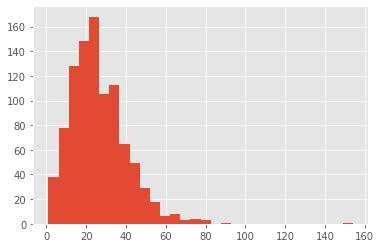

In [4]:
plt.hist([len(s) for s in sentences], bins=30)
plt.show()


In [5]:
#Words Array Max 
MAX_LENGTH = max([len(s) for s in sentences])
print("Max Length: " + str(MAX_LENGTH))

words = list(set(train.words() + test.words()))
words.append("ENDPAD")
N_WORDS = len(words) 

print("Number of words: " + str(N_WORDS))


tags = list(set(flatten([[tpl[1] for tpl in rec] for rec in sentences])))
N_TAGS = len(tags)

word_index = { w: i for i,w in enumerate(words) }
tag_index  = { t: i for i,t in enumerate(tags)  }

# from collections import Counter 
# o_count = Counter(flatten([[tpl[1] for tpl in rec] for rec in sentences])); 
# print(o_count)

X =[[word_index[word[0]] for word in sentence] for sentence in sentences]

X_TRAIN = pad_sequences(maxlen=MAX_LENGTH, 
                        sequences=X,
                        padding="post", value=N_WORDS-1)

Y =[[tag_index[word[1]] for word in sentence] for sentence in sentences]


Y_TRAIN = pad_sequences(maxlen=MAX_LENGTH, 
                        sequences=Y,
                        padding="post", value=tag_index['O'])

Y_TRAIN = [to_categorical(i, num_classes=N_TAGS) for i in Y_TRAIN]


from sklearn.model_selection import train_test_split
X_TRAIN, X_TEST, Y_TRAIN, Y_TEST = train_test_split(X_TRAIN,Y_TRAIN, test_size=0.2)

# X_TEST = [ [word_index[word[0]] for word in sentence] for sentence in test_sentences]

# X_TEST = pad_sequences(maxlen=MAX_LENGTH, 
#                         sequences=X_TEST,
#                         padding="post", value=N_WORDS-1)

# #Y_TEST =[[tag_index[word[1]] for word in sentence] for sentence in sentences]

# Y_TEST = pad_sequences(maxlen=MAX_LENGTH, 
#                         sequences=Y_TEST,
#                         padding="post", value=tag_index['O'])

# Y_TEST = [to_categorical(i, num_classes=N_TAGS) for i in Y_TEST]



Max Length: 154
Number of words: 4295


In [6]:
input = Input(shape=(MAX_LENGTH,))
model = Embedding(input_dim=N_WORDS, output_dim=N_TAGS, input_length=MAX_LENGTH)(input)
model = Dropout(0.1)(model) 
model = Bidirectional(LSTM(units=100, return_sequences=True, recurrent_dropout=0.1))(model)
out   = TimeDistributed(Dense(N_TAGS, activation='softmax'))(model)

model = Model(input, out)
model.compile(optimizer="adam", loss="categorical_crossentropy", metrics=['accuracy'])
model.fit(X_TRAIN, np.array(Y_TRAIN), batch_size=32, epochs=20, validation_split=0.2, verbose =1)


C:\Users\crown\Anaconda2\envs\tensorflow_cpu\lib\site-packages\tensorflow\python\ops\gradients_impl.py:100: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Train on 617 samples, validate on 155 samples
Epoch 1/20
617/617 [==============================] - 11s 18ms/step - loss: 0.9285 - acc: 0.9017 - val_loss: 0.4029 - val_acc: 0.9456
Epoch 2/20
617/617 [==============================] - 8s 13ms/step - loss: 0.3379 - acc: 0.9469 - val_loss: 0.2992 - val_acc: 0.9456
Epoch 3/20
617/617 [==============================] - 8s 13ms/step - loss: 0.2801 - acc: 0.9469 - val_loss: 0.2497 - val_acc: 0.9456
Epoch 4/20
617/617 [==============================] - 8s 13ms/step - loss: 0.2426 - acc: 0.9469 - val_loss: 0.2319 - val_acc: 0.9456
Epoch 5/20
617/617 [==============================] - 8s 13ms/step - loss: 0.2334 - acc: 0.9469 - val_loss: 0.2269 - val_acc: 0.9456
Epoch 6/20
617/617 [==============================] - 8s 13ms/step - loss: 0.2297 - acc: 0.9469 - val_loss: 0.2244 - val_acc: 0.9456
Epoch 7/20
617/617 [==============================] - 8s 13ms/step - loss: 0.2262 - acc: 0.9469 - val_loss: 0.2217 - val_acc: 0.9456
Epoch 8/20
617/617 [==

In [7]:
i = 6
p = model.predict(np.array([X_TEST[i]]))
p = np.argmax(p, axis=-1)

print("{:14} ({:5}): {}".format("Word", "True", "Pred"))
for w,pred in zip(X_TEST[i],p[0]):
    print("{:14}: {}".format(words[w],tags[pred]))
    
#print(len(X_TRAIN[36]))
#print(words[X_TRAIN[4][1]])

model.save('inital.model')

Word           (True ): Pred
The           : O
most          : O
recent        : O
airstrikes    : O
bring         : O
the           : O
total         : O
number        : O
of            : O
munitions     : O
in            : O
support       : O
of            : O
the           : O
SDF           : I-Organisation
since         : O
Dec.          : O
5             : O
to            : O
922           : O
,             : O
he            : O
added         : O
.             : O
ENDPAD        : O
ENDPAD        : O
ENDPAD        : O
ENDPAD        : O
ENDPAD        : O
ENDPAD        : O
ENDPAD        : O
ENDPAD        : O
ENDPAD        : O
ENDPAD        : O
ENDPAD        : O
ENDPAD        : O
ENDPAD        : O
ENDPAD        : O
ENDPAD        : O
ENDPAD        : O
ENDPAD        : O
ENDPAD        : O
ENDPAD        : O
ENDPAD        : O
ENDPAD        : O
ENDPAD        : O
ENDPAD        : O
ENDPAD        : O
ENDPAD        : O
ENDPAD        : O
ENDPAD        : O
ENDPAD        : O
ENDPAD        : O
ENDP

ImportError: `save_model` requires h5py.